In [1]:
import glob
import io
from ipywidgets import interact
from ipywidgets import fixed
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
# import openslide
# from openslide import open_slide
import re
from scipy import ndimage as ndi
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops
import seaborn as sns
import json
import SimpleITK as sitk
from collections import OrderedDict
# from skimage.color import rgb2hed
from skimage.exposure import histogram
# from skimage.filters import threshold_otsu
from skimage import morphology
from skimage.transform import rotate
from skimage.color import rgb2gray, rgb2hed
from skimage.filters import sobel, threshold_otsu
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import measure
import time
import warnings
import cv2
from scipy.optimize import minimize, rosen, rosen_der
import collections
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import OrderedDict
import matplotlib.font_manager as font_manager
import matplotlib.patches as mpatches

In [2]:
original_czi1_size = (54513, 23814)
original_czi2_size = (56032, 20210)
original_czi3_size = (46345, 15101)
original_czi4_size = (49087, 18570)
#-----------------------------------------------------------
original_czi1_size_s2 = (49329, 21951)
original_czi2_size_s2 = (18361, 45640)
# 32884.84848484848 14824.242424242424
original_czi3_size_s2 = (32812, 14792)
original_czi4_size_s2 = (14870, 34710)

big_window = 0.1
medium_window = 0.25*0.1
small_window = 0.5*medium_window

In [3]:
def get_files_in_directory(directory, postfix=""):
    fileNames = [s for s in os.listdir(directory) if not os.path.isdir(os.path.join(directory, s))]
    if not postfix or postfix == "":
        return sorted(fileNames)
    else:
        return sorted([s for s in fileNames if s.lower().endswith(postfix)])
    
def get_files_in_dir_recursively(directory, postfix='json'):
    files = [file for file in glob.glob(os.path.join(directory, '**/*.{0}'.format(postfix)), recursive=True)]
    return files

def get_subdirectories_in_directory(directory, postfix=""):
    dir_names = [s for s in os.listdir(directory) if os.path.isdir(os.path.join(directory, s))]
    return sorted(dir_names)

def mkdirs(dirs):
    if not os.path.exists(dirs):
        os.makedirs(dirs)


def convert_original2scaled(x_coord, y_coord, scaled_size, original_size=original_czi1_size, exclude_rate_h=1.0, exclude_rate_w=1.0):
    return int(x_coord*scaled_size[0]/(original_size[0]*exclude_rate_w)), int(y_coord*scaled_size[1]/(original_size[1]*exclude_rate_h))


def list_to_int(list1D):
    return [int(float(x)) for x in list1D]

def draw_rectangles(img, rects, color=(0, 255, 255), thickness=7):
    clone_image = img.copy()
    for rect in rects:
        pt1 = tuple(list_to_int(rect[0:2]))
        pt2 = tuple(list_to_int(rect[2:]))
        cv2.rectangle(clone_image, pt1, pt2, color, thickness, cv2.FILLED)
    return clone_image

def get_xy_from_fn(fn):
    results = re.findall('x(\d+)_y(\d+)', fn)
    if len(results) == 1:
        x_coord, y_coord = results[0]
        x_coord, y_coord = int(x_coord), int(y_coord)
        return x_coord, y_coord, None
    else:
        x_coord, y_coord = results[-1]
        x_coord, y_coord = int(x_coord), int(y_coord)
        return x_coord, y_coord, [list_to_int(element) for element in results[:-1]]

def substite_file_name(file_name, pattern = 'Cy7',sub_string='Cy5'):
    output = re.sub(pattern, sub_string, file_name)
    return output 

def thumbnail(img, size = (1000,1000)):
    img_thumbnail = img.copy()
    img_thumbnail.thumbnail(size)
    return img_thumbnail

In [4]:
def get_itk_from_pil(pil_img):
    """Converts Pillow image into ITK image
    """
    return sitk.GetImageFromArray(np.array(pil_img))

def get_pil_from_itk(itk_img):
    """Converts ITK image into Pillow Image
    """
    return Image.fromarray(sitk.GetArrayFromImage(itk_img).astype(np.uint8))

def show_alignment(fixed_img, moving_img, prefilter = None):
    """Visualises alignment of fixed image with moving image
    
    Fixed image is displayed as blue
    Moving image is displayed as pink 
    """
    if prefilter == 'TP53':
        tp53_filtered = filter_green(moving_img)
        tp53_filtered = filter_grays(tp53_filtered, tolerance = 3)
        moving_img = filter_otsu_global(tp53_filtered, 'PIL')
        he_filtered = filter_green(fixed_img)
        he_filtered = filter_grays(he_filtered, tolerance = 15)
        fixed_img = filter_otsu_global(he_filtered, 'PIL')
    background = (255,255,255)
    img_red = ImageOps.colorize(moving_img.convert('L'), (255, 0, 0), background)
    img_blue = ImageOps.colorize(fixed_img.convert('L'), (0, 0, 255), background)
    img_red.putalpha(120)
    img_blue.putalpha(70)
    return Image.alpha_composite(img_red, img_blue)

def sitk_transform_rgb(moving_rgb_img, fixed_rgb_img, transform, interpolator = sitk.sitkLanczosWindowedSinc):
    """Applies a Simple ITK transform (e.g. Affine, B-spline) to an RGB image
    
    The transform is applied to each channel
    
    Parameters
    ----------
    moving_rgb_img : Pillow Image 
        This image will be transformed to produce the output image
    fixed_rgb_img : Pillow Image
        This reference image provides the output information (spacing, size, and direction) of the output image
    transform : SimpleITK transform
        Generated from image registration
    interpolator : SimpleITK interpolator
    
    Returns
    -------
    rgb_transformed : Pillow Image
        Transformed moving image 
    """
    transformed_channels = []
    r_moving, g_moving, b_moving, = moving_rgb_img.convert('RGB').split()
    r_fixed, g_fixed, b_fixed = fixed_rgb_img.convert('RGB').split()
    for moving_img, fixed_img in [(r_moving, r_fixed), (g_moving, g_fixed), (b_moving, b_fixed)]:
        moving_img_itk = get_itk_from_pil(moving_img)
        fixed_img_itk = get_itk_from_pil(fixed_img)
        transformed_img = sitk.Resample(moving_img_itk, fixed_img_itk, transform, 
                            interpolator, 0.0, moving_img_itk.GetPixelID())
        transformed_channels.append(get_pil_from_itk(transformed_img))
    rgb_transformed = Image.merge('RGB', transformed_channels)
    return rgb_transformed    

def start_plot():
    """Setup data for plotting
    
    Invoked when StartEvent happens at the beginning of registration.
    """
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

def end_plot():
    """Cleanup the data and figures 
    """
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show() 
    
def update_plot(registration_method):
    """Plot metric value after each registration iteration
    
    Invoked when IterationEvent happens.
    """
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number', fontsize=12)
    plt.ylabel('Metric', fontsize=12)
    plt.show()
    
def update_multires_iterations():
    """Update the index in the metric values list that corresponds to a change in registration resolution
    
    Invoked when the sitkMultiResolutionIterationEvent happens.
    """
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
def plot_metric(title = 'Plot of registration metric vs iterations'):
    """Plots the mutual information over registration iterations
    
    Parameters
    ----------
    title : str
    
    Returns
    -------
    fig : matplotlib figure
    """
    global metric_values, multires_iterations
    
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel('Iteration Number', fontsize=12)
    ax.set_ylabel('Mutual Information Cost', fontsize=12)
    ax.plot(metric_values, 'r')
    ax.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*', label = 'change in resolution')
    ax.legend()
    return fig

################################
# Mutual Information Functions #
################################

def mutual_information(hgram):
    """Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis = 1) # marginal for x over y
    py = np.sum(pxy, axis = 0) # marginal for y over x
    px_py = px[:, None] * py[None, :] #Broadcat to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def mutual_info_histogram(fixed_img, moving_img, bins = 20, log = False):
    hist_2d, x_edges, y_edges = np.histogram2d(fixed_img.ravel(), moving_img.ravel(), bins = bins)
    if log:
        hist_2d_log = np.zeros(hist_2d.shape)
        non_zeros = hist_2d != 0
        hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
        return hist_2d_log
    return hist_2d

def plot_mutual_info_histogram(histogram):
    plt.imshow(histogram.T, origin = 'lower')
    plt.xlabel('Fixed Image')
    plt.ylabel('Moving Image')

def calculate_mutual_info(fixed_img, moving_img):
    hist = mutual_info_histogram(fixed_img, moving_img)
    return mutual_information(hist)

In [5]:
def overlay_pil_imgs(foreground, background, best_loc = (0,0), alpha=0.5):
    newimg1 = Image.new('RGBA', size=background.size, color=(0, 0, 0, 0))
    newimg1.paste(foreground, best_loc)
    newimg1.paste(background, (0, 0))

    newimg2 = Image.new('RGBA', size=background.size, color=(0, 0, 0, 0))
    newimg2.paste(background, (0, 0))
    newimg2.paste(foreground, best_loc)
    result = Image.blend(newimg1, newimg2, alpha=alpha)
    return result

def transform_point(transform, point):
    transformed_point = transform.TransformPoint(point, )
    return transformed_point
#     print('Point ' + str(point) + ' transformed is ' + str(transformed_point))

def convert_rect_coords(transform, rects):
    x1, y1, x2, y2 = rects
    transformed_x1, transformed_y1 = transform_point(transform, (x1, y1))
    transformed_x2, transformed_y2 = transform_point(transform, (x2, y2))
    transformed_rect = (transformed_x1, transformed_y1, transformed_x2, transformed_y2)
    return transformed_rect


def y_element(element):
    return element[0]
def x_element(element):
    return element[1]
def xy_element(element):
    return element[0]+ element[1]

In [6]:
def map_heat_values2colors(values):
    colors = list()
#     count = 0
    sorted_values = np.sort(values, kind='mergesort')
    set_box_scores = list(OrderedDict.fromkeys(sorted_values).keys())
    heat_colors_range = sns.color_palette('viridis', len(set_box_scores))
    for value in values:
        if value == 0:
            raw_color = [0,0,0]
        else:
            raw_color = heat_colors_range[set_box_scores.index(value)]
        colors.append(raw_color)
#         if set_box_scores.index(value) > 49:
#             count+= 1
#     print(count)
    return np.array(colors)

def draw_rectangles_heat(img, rects, colors, scores):
    clone_image = img.copy()
    for index, rect in enumerate(rects):
        pt1 = tuple(list_to_int(rect[0:2]))
        pt2 = tuple(list_to_int(rect[2:]))
        cv2.rectangle(clone_image, pt1, pt2, colors[index], cv2.FILLED)
#         print(scores[index])
#         cv2.putText(clone_image, str(scores[index]), tuple((pt1[0], pt1[1])), cv2.FONT_HERSHEY_SIMPLEX, 
#                     50, color=(255,255,255))
    return clone_image

def collocalize_score(fn):
    equivalent_cy7_fn = substite_file_name(fn, 'DAPI', 'Cy7')
    equivalent_cy5_fn = substite_file_name(fn, 'DAPI', 'Cy5')
    with open(fn) as json_file:
        dapi_json = json.load(json_file)
    cell_counts = len(dapi_json)
    if os.path.exists(equivalent_cy7_fn) and os.path.exists(equivalent_cy5_fn):
        try:
            with open(equivalent_cy7_fn) as json_file:
                cy7_json = json.load(json_file)
            present_cy7 = len(cy7_json)
        except:
            present_cy7 = 0
        try: 
            with open(equivalent_cy5_fn) as json_file:
                cy5_json = json.load(json_file)
            present_cy5 = len(cy5_json)
        except: 
            present_cy5 = 0  
    if present_cy5 == 0 or present_cy7 == 0:
        return 0#, 0
#     if (present_cy5+present_cy7)/cell_counts > 5:
#         print(present_cy5, present_cy7, cell_counts)
    return (present_cy5+present_cy7)/cell_counts#, (present_cy5+present_cy7)

def normalize_score_by_rect(score, rect):
    area = abs(rect[2] - rect[0])*abs(rect[3]-rect[1])
    return score

def area_of_rect(rect):
    x1, y1, x2, y2 = rect
    return abs(x2-x1)*abs(y2-y1)

In [7]:
def parse_measurement_string(measurement_string):
    result = re.sub(r"\[|\]", '',measurement_string)
    elements = result.split(', ')
    data_dict = collections.OrderedDict()
    for element in elements:
        float_value = re.findall("-?\d+\.\d+|NaN", element)
        if len(float_value) == 0:
            key_value, name = re.split(' ', element)
            data_dict[key_value[:-1]] = name
        else:
            exponents = re.findall("([eE][-+]?[0-9]+)", element)
            if len(exponents) > 0:
#                 print(str(float_value[0])+str(exponents[0]))
                key_value = re.sub(str(float_value[0])+str(exponents[0]), '', element)
                data_dict[key_value[:-2]] = float(str(float_value[0])+str(exponents[0]))
            else:
                key_value = re.sub(float_value[0], '', element)
                if float_value[0] == 'NaN':
                    data_dict[key_value[:-2]] = float(0.0)
                else:
                    data_dict[key_value[:-2]] = float(float_value[0])

    return pd.DataFrame(data_dict, index=[0]), data_dict.keys()

def convert_json2dataframe(fn, col_names = list()):
    with open(fn) as json_file:
        json_values = json.load(json_file)
#     print(col_names)
    if len(json_values) != 0:
        try:
            measure_values, row_name = parse_measurement_string(json_values[0])
        except:
            print(fn)
#             1/0
        for element in json_values[1:]:
            frame, keys = parse_measurement_string(element)
            measure_values = measure_values.append(frame, ignore_index=True)
        return measure_values
    else:
        if len(col_names) == 0:
            raise Exception("No value found", fn)
        else:
            measure_values = pd.DataFrame(columns= col_names)
            return measure_values
        
def inverse_transform_point(xform, p):
    """
    Returns the inverse-transform of a point.

    :param sitk.Transform xform: The transform to invert
    :param (float,float)|[float|float]|np.ndarray p: The point to find inverse for
    :return np.ndarray, bool: The point and whether the operation succeeded or not
    """

    def fun(x):
        return np.linalg.norm(xform.TransformPoint(x) - p)

    p = np.array(p)
    res = minimize(fun, p, method='Powell')
    return res.x, res.success

# def transform_point(transform, point):
#     transformed_point = transform.TransformPoint(point)
#     return transformed_point
#     print('Point ' + str(point) + ' transformed is ' + str(transformed_point))

def convert_rect_coords(transform, rects):
    x1, y1, x2, y2 = rects
#     print(rects)
    top_left, state_1 = inverse_transform_point(transform, (x1, y1))
    bottom_right, state_2 = inverse_transform_point(transform, (x2, y2))
    transformed1_x1, transformed1_y1 = top_left
    transformed1_x2, transformed1_y2 = bottom_right
    transformed_rect = (transformed1_x1, transformed1_y1, transformed1_x2, transformed1_y2)
#     print(transformed_rect)
#     1/0
    return transformed_rect

In [11]:
material_path = '/QRISdata/Q1851/Minh/RNAScope/Tiff_images_all_2/Tissue_1_E15/'
round1_dapi = '2020_05_05_R1_DAPI_TIFF/'
round2_dapi = '2020_05_06_R2_DAPI_TIFF/'
dapi_1 = os.path.join(material_path, round1_dapi, '2020_05_05_R1_DAPI_TIFF_s1z1c4.tif')
dapi_2 = os.path.join(material_path, round2_dapi, '2020_05_06_R2_DAPI_TIFF_s1z1c3.tif')
qupath_output = '/QRISdata/Q1851/Minh/RNAScope/QuPath_project_1/'

In [13]:
round1_all = '2020_05_05_R1_THY1_IL34_CSFR1_DAPI_TIFF/'
round2_all = '2020_05_06_R2_ITGAM_CD207_DAPI_TIFF/'
all_channel_fn1 = '2020_05_05_R1_THY1_IL34_CSFR1_DAPI_TIFF_s1z1c1-4.tif'
all_channel_fn2 = '2020_05_06_R2_ITGAM_CD207_DAPI_TIFF_s1z7c1-3.tif'
all_1 = os.path.join(material_path, round1_all, all_channel_fn1)
all_2 = os.path.join(material_path, round2_all, all_channel_fn2)
img_dapi1 = cv2.cvtColor(cv2.imread(all_1), cv2.COLOR_BGR2RGB)
img_dapi2 = cv2.cvtColor(cv2.imread(all_2), cv2.COLOR_BGR2RGB)
pil_img_dapi1 = Image.fromarray(img_dapi1)
pil_img_dapi2 = Image.fromarray(img_dapi2)
dapi1_gray = pil_img_dapi1.convert('L')
dapi2_gray = pil_img_dapi2.convert('L')
dapi1_gray_itk = get_itk_from_pil(dapi1_gray)
dapi2_gray_itk = get_itk_from_pil(dapi2_gray)
fixed_img = dapi1_gray_itk
moving_img = dapi2_gray_itk

In [14]:
affine_transform = sitk.ReadTransform('part_1_registration_affine_transform.tfm')
bspline_transform = sitk.ReadTransform('part_2_registration_bspline_transform.tfm')

In [15]:
moving_rgb_affine = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, affine_transform)
moving_rgb_final_4 = sitk_transform_rgb(moving_rgb_affine, pil_img_dapi1, bspline_transform)
# thumbnail(show_alignment(he, moving_rgb_final, prefilter = True))
# moving_rgb_final_3 = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, bspline_transform)
print(moving_rgb_final_4.size)
change_color_mv_rgb_final_4 = np.array(moving_rgb_final_4)
print(change_color_mv_rgb_final_4.shape)
converted_color = cv2.cvtColor(change_color_mv_rgb_final_4, cv2.COLOR_BGR2RGB)
foreground = Image.fromarray(converted_color)
background = pil_img_dapi1

(7859, 17989)
(17989, 7859, 3)


In [16]:
overlayed_imgs_tissue1 = overlay_pil_imgs(background=background, foreground=foreground, alpha=0.4)

In [18]:
# scene1_output_dir2 = os.path.join(qupath_output, 'Scene_1_R2.3')
scene1_output_dir2 = os.path.join(qupath_output, 'Scene_1_R2.3')
list_output_files_s2 = get_files_in_dir_recursively(scene1_output_dir2)
all_collocalized_rects_s2 = list()

box_collocalized_scores_s2 = list()
child_count_s2 = dict()

for fn in list_output_files_s2:
    if 'DAPI' in fn:
        x_coord, y_coord, parent_annots = get_xy_from_fn(fn)
        if parent_annots is not None:
            for index, parent_annot in enumerate(parent_annots):
                if child_count_s2.get('_'.join(str(i) for i in parent_annot), None) is None:
                    
                    x_par, y_par = parent_annot
                    annot_x, annot_y = convert_original2scaled(x_par, y_par, 
                                                               (img_dapi2.shape[0], img_dapi2.shape[1]), 
                                                               original_czi1_size_s2)
                    if index == 0:
                        par_rect = [annot_x, 
                                    annot_y, 
                                    annot_x+int(big_window*img_dapi2.shape[1]),
                                    annot_y+int(big_window*img_dapi2.shape[0]*0.8)]
                    elif index == 1:
                        par_rect = [annot_x, 
                                    annot_y, 
                                    annot_x+int(medium_window*img_dapi2.shape[1]),
                                    annot_y+int(medium_window*img_dapi2.shape[0]*0.8)]
                    all_collocalized_rects_s2.append(par_rect)
#                     score = collocalize_score(fn)
                    child_count_s2['_'.join(str(i) for i in parent_annot)] = 1
                    box_collocalized_scores_s2.append(0)

                else:
                    child_count_s2['_'.join(str(i) for i in parent_annot)] += 1
                    annot_x, annot_y = convert_original2scaled(x_coord, y_coord, 
                                                               (img_dapi2.shape[0], img_dapi2.shape[1]), 
                                                               original_czi1_size_s2)
                    if len(parent_annots) == 1:
                        ratio = medium_window
                    elif len(parent_annots) == 2:
                        ratio = small_window
                    rect = [annot_x, 
                            annot_y, 
                            annot_x+int(ratio*img_dapi2.shape[1]),
                            annot_y+int(ratio*img_dapi2.shape[0]*0.8)]
                    all_collocalized_rects_s2.append(rect)
                    score = collocalize_score(fn)
#                     if score > 4:
#                         print(score, rect)
#                         print(fn)
                    box_collocalized_scores_s2.append(normalize_score_by_rect(score, rect))
        else:
            annot_x, annot_y = convert_original2scaled(x_coord, y_coord, 
                                                       (img_dapi2.shape[0], img_dapi2.shape[1]), 
                                                       original_czi2_size_s2)
            rect = [annot_x, 
                    annot_y, 
                    annot_x+int(big_window*img_dapi2.shape[1]),
                    annot_y+int(big_window*img_dapi2.shape[0]*0.8)]
            all_collocalized_rects_s2.append(rect)
#             score = collocalize_score(fn)
            box_collocalized_scores_s2.append(0)


box_collocalized_scores_s2 = np.array(box_collocalized_scores_s2)
# std_scaler = StandardScaler()
# stded_box_score = std_scaler.fit_transform(box_collocalized_scores.reshape(-1,1))
# print(stded_box_score.mean(), stded_box_score.std())
# print(stded_box_score.reshape(box_collocalized_scores.shape))
heat_colors2 = np.array(map_heat_values2colors(box_collocalized_scores_s2))
# print(heat_colors[10:25])
heat_colors2 = heat_colors2 * 255
# print(heat_colors[10:25])
print(len(all_collocalized_rects_s2))
heat_demo_image_s2 = draw_rectangles_heat(np.zeros_like(img_dapi2), all_collocalized_rects_s2,
                                       heat_colors2, box_collocalized_scores_s2)


3831


In [19]:
registered_boxes_bspline = list()
registered_boxes_affine = list()
for rect in all_collocalized_rects_s2:
    transformed1_rect = convert_rect_coords(affine_transform, rect)
    transformed2_rect = convert_rect_coords(bspline_transform, transformed1_rect)
    registered_boxes_affine.append(transformed1_rect)
    registered_boxes_bspline.append(transformed2_rect)

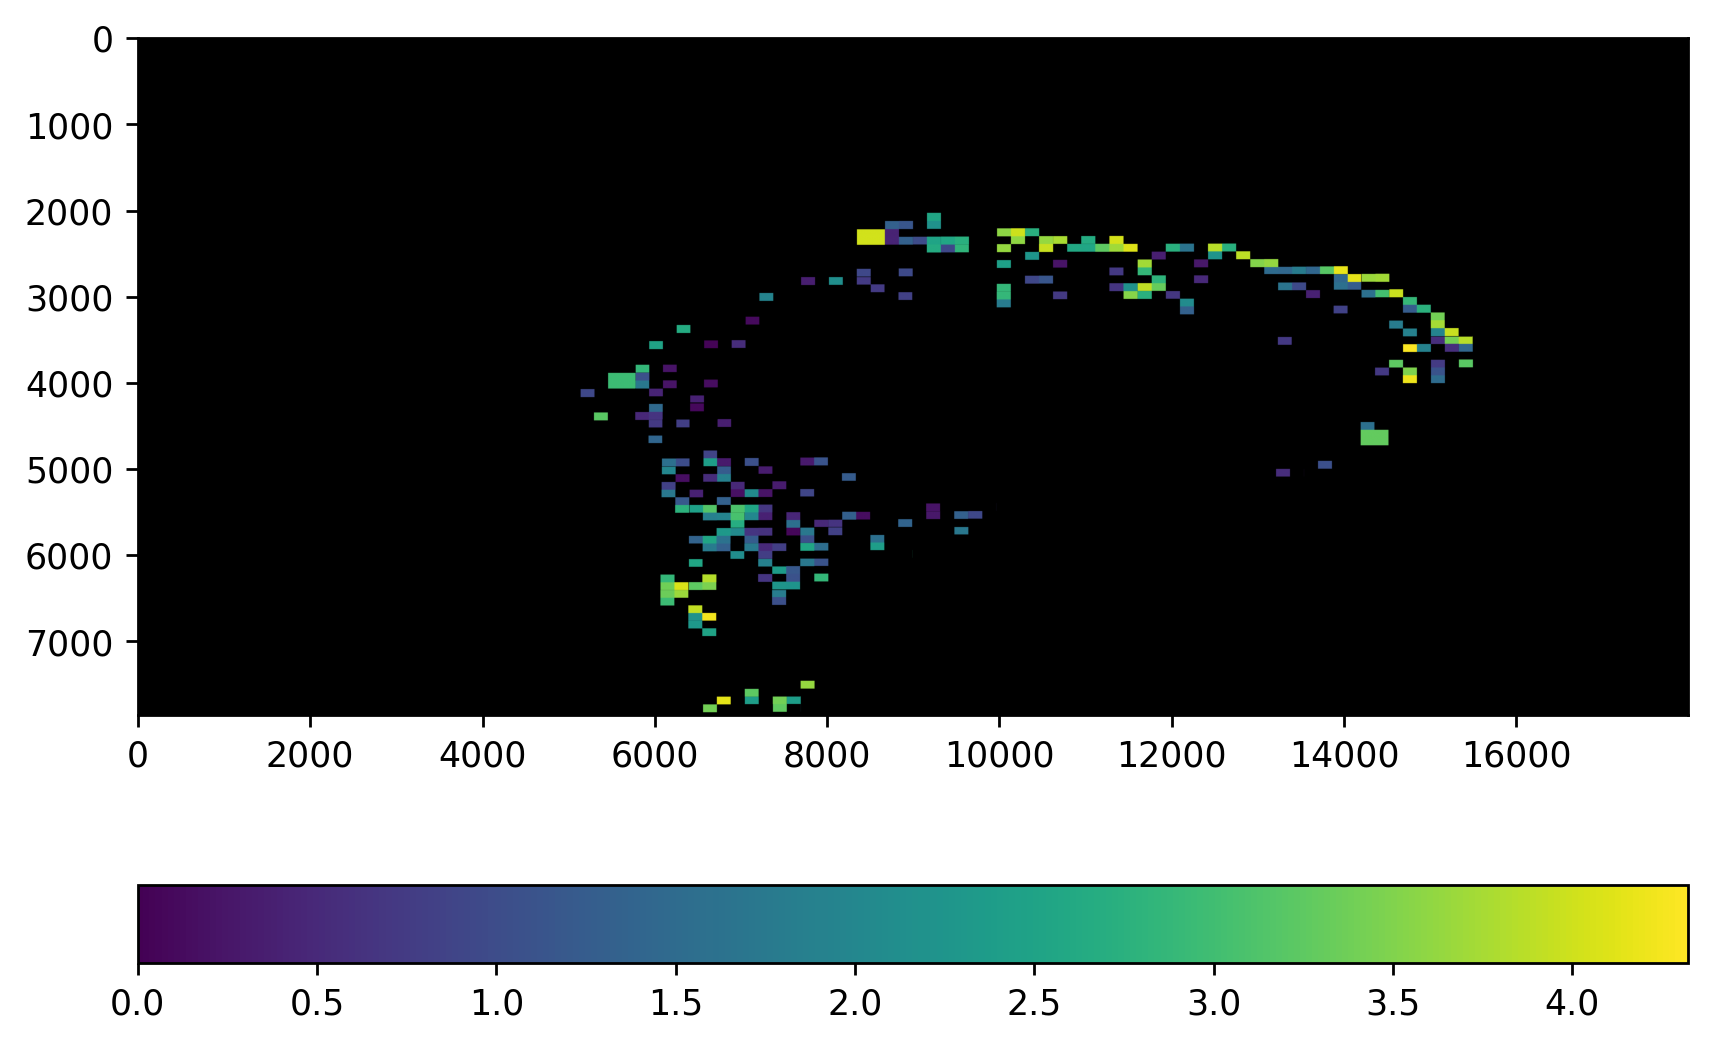

In [35]:
heat_demo_image_s1_and_s2 = draw_rectangles_heat(np.zeros_like(img_dapi1), 
                                                 registered_boxes_bspline,
                                                 heat_colors2, 
                                                 box_collocalized_scores_s2)

rotated_heat_demo_image_s12 = rotate(heat_demo_image_s1_and_s2, -90, resize=True)

plt.figure(num=None, figsize=(8, 6), dpi=250, facecolor='w', edgecolor='k')
plt.imshow(rotated_heat_demo_image_s12, vmax=box_collocalized_scores_s2.max(), vmin=box_collocalized_scores_s2.min())
plt.colorbar(orientation='horizontal')

In [36]:
contours = np.load('scene1_contours.npy',allow_pickle=True)
x0, x1, y0, y1 = np.load('scene1_padding.npy')


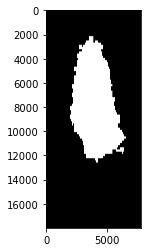

In [38]:
mask_binary = np.zeros_like(cv2.cvtColor(img_dapi1, cv2.COLOR_RGB2GRAY))
for n, contour in enumerate(contours[0:1]):
    mask_binary[np.round(contours[n][:, 0]).astype('int'), np.round(contours[n][:, 1]).astype('int')] = 1
fill_contour = ndi.binary_fill_holes(mask_binary)
fill_contour = fill_contour.astype('int')
plt.imshow(np.array(fill_contour), cmap='gray')

In [39]:
def rotate_contour(contour_points, angle, center):
    new_ct_pts = np.zeros_like(contour_points)
    for index, points in enumerate(contour_points):
        x, y = points
        new_y = (y - center[1])*np.cos(np.pi*angle/180) + (x - center[0])*np.sin(np.pi*angle/180) + center[1]
        new_x = -(y- center[1])*np.sin(np.pi*angle/180) + (x- center[0])*np.cos(np.pi*angle/180) + center[0]
        new_y = new_y - (center[1] -  center[0])
        new_x = new_x +  (center[1] -  center[0])
        new_ct_pts[index] = np.array([np.abs(new_x), np.abs(new_y)])
    return new_ct_pts

In [43]:
def contour_transform(contour_points):
    new_ct_pts = np.zeros_like(contour_points)
    for index, points in enumerate(contour_points):
        new_pt1, state_1 = inverse_transform_point(affine_transform, points)
        new_pt2, state_2 = inverse_transform_point(bspline_transform, new_pt1)
        new_ct_pts[index] = new_pt2
    return new_ct_pts

(-0.5, 17988.5, 7858.5, -0.5)

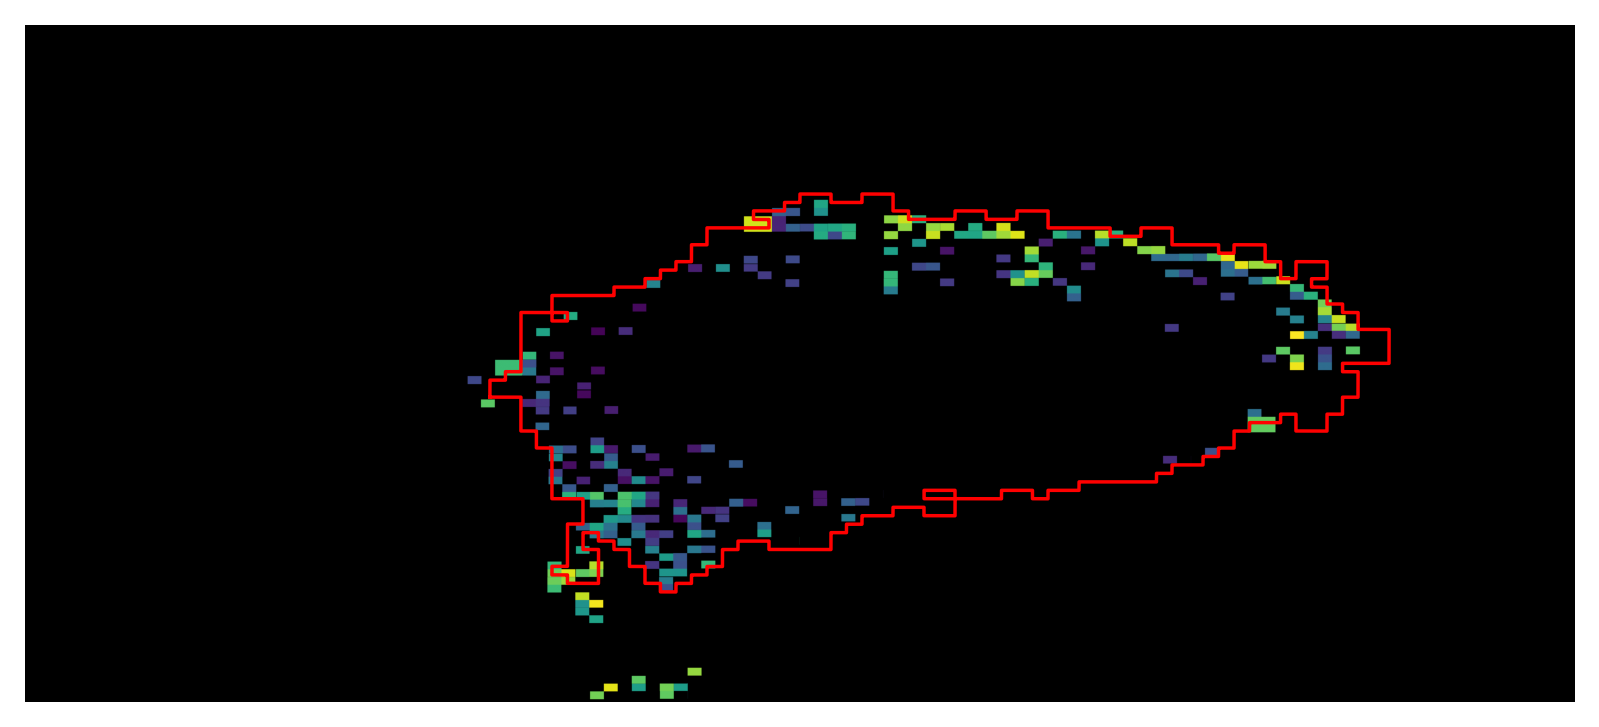

In [44]:
center_x, center_y, _ = heat_demo_image_s1_and_s2.shape
center = (center_x/2-0.5, center_y/2-0.5)
fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=250, facecolor='w', edgecolor='k')

map_color = ax.imshow(rotated_heat_demo_image_s12, vmin=box_collocalized_scores_s2.min(), vmax=box_collocalized_scores_s2.max())
for n, contour in enumerate(contours[0:1]):
    rotated_contour = rotate_contour(contour, -90, center)
    transform_contour = contour_transform(rotated_contour)
    ax.plot(rotated_contour[:, 1], rotated_contour[:,0], 'r',linewidth=1)
# fig.colorbar(map_color, orientation='horizontal')
# plt.gca().invert_yaxis()
# ax.set_ylim(x0,x1)
# ax.set_xlim(y0,y1)
# plt.gca().invert_yaxis()
plt.axis('off')
# plt.savefig('collocalization_scene1_ITGAM_THY1_1.jpg')

In [45]:
contours = np.load('scene1_contours_r2.npy',allow_pickle=True)
x0, x1, y0, y1 = np.load('scene1_padding.npy')

In [ ]:
center_x, center_y, _ = heat_demo_image_s1_and_s2.shape
center = (center_x/2-0.5, center_y/2-0.5)
fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=250, facecolor='w', edgecolor='k')

map_color = ax.imshow(rotated_heat_demo_image_s12, vmin=box_collocalized_scores_s2.min(), vmax=box_collocalized_scores_s2.max())
for n, contour in enumerate(contours[0:1]):
    rotated_contour = rotate_contour(contour, -90, center)
    transform_contour = contour_transform(rotated_contour)
    ax.plot(rotated_contour[:, 1], rotated_contour[:,0], 'r',linewidth=1)
# fig.colorbar(map_color, orientation='horizontal')
# plt.gca().invert_yaxis()
# ax.set_ylim(x0,x1)
# ax.set_xlim(y0,y1)
# plt.gca().invert_yaxis()
plt.axis('off')
# plt.savefig('collocalization_scene1_ITGAM_THY1_1.jpg')